# Data Cleaning and Feature Extraction

This notebook handles data cleaning and feature extraction from audio files for language recognition.


## Import Libraries


In [ ]:
from IPython.display import Audio, display
import numpy as np
import pandas as pd
import os
from glob import glob
import warnings
import joblib

import librosa
import soundfile as sf

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Load Data


In [39]:
DATA_PATH = "./raw"

files = []
for language in os.listdir(DATA_PATH):
    lang_path = os.path.join(DATA_PATH, language)
    if os.path.isdir(lang_path):
        for gender in os.listdir(lang_path):
            gender_path = os.path.join(lang_path, gender)
            if os.path.isdir(gender_path):
                for filename in glob(os.path.join(gender_path, "*.mp3")):
                    files.append({
                        "filepath": filename,
                        "language": language.lower(),
                        "gender": gender.lower(),
                        "filename": os.path.basename(filename)
                    })

df = pd.DataFrame(files)
print(f"Total files: {len(df)}")
print(df.groupby(['language', 'gender']).size())

Total files: 720
language  gender
german    female    90
          male      90
italian   female    90
          male      90
korean    female    90
          male      90
spanish   female    90
          male      90
dtype: int64


### Data preview


In [ ]:
print("Sample audio files:\n")
samples = df.sample(3) 
for _, row in samples.iterrows():
    print(f"Language: {row['language']} | Gender: {row['gender']}")
    print(f"File: {row['filename']}")
    display(Audio(row['filepath']))
    print("-" * 50)

Sample audio files:

Language: italian | Gender: male
File: 810102393_male_italian_voice06.mp3


--------------------------------------------------
Language: italian | Gender: male
File: 810102393_male_italian_voice16.mp3


--------------------------------------------------
Language: german | Gender: female
File: 810104170_female_german_voice18.mp3


--------------------------------------------------


## Data Cleaning


In [ ]:
# Extract metadata from filename for comparison
def parse_filename(filename):
    """Extract gender and language from filename if present"""
    parts = filename.lower().split('_')
    file_gender = None
    file_language = None
    for part in parts:
        if part in ['male', 'female']:
            file_gender = part
        if part in ['german', 'italian', 'korean', 'spanish', 'koren']:
            file_language = 'korean' if part == 'koren' else part
    return file_gender, file_language

# Apply parsing
df[['file_gender', 'file_language']] = df['filename'].apply(
    lambda x: pd.Series(parse_filename(x))
)

# Check mismatches (folder is source of truth)
gender_mismatch = df['file_gender'] != df['gender']
language_mismatch = df['file_language'] != df['language']

print(f"Gender mismatches: {gender_mismatch.sum()}")
print(f"Language mismatches: {language_mismatch.sum()}")

# Use folder structure as ground truth
# Drop the file-extracted columns, keep folder-based ones
df = df.drop(columns=['file_gender', 'file_language'])

# Extract student_id from filename
df['student_id'] = df['filename'].apply(lambda x: x.split('_')[0])

# Validate audio files and get duration
def validate_audio(filepath):
    try:
        duration = librosa.get_duration(path=filepath)
        return True, duration
    except:
        return False, 0

# Apply validation
print("Validating audio files...")
df[['valid', 'duration']] = df['filepath'].progress_apply(
    lambda x: pd.Series(validate_audio(x))
)

# Report
invalid_count = (~df['valid']).sum()
print(f"Invalid files: {invalid_count}")
if df['valid'].any():
    print(f"Duration range: {df['duration'].min():.1f}s - {df['duration'].max():.1f}s")

# Keep only valid files
df_clean = df[df['valid']].copy()
print(f"Clean dataset: {len(df_clean)} files")

Gender mismatches: 0
Language mismatches: 0
Validating audio files...


100%|██████████| 720/720 [00:00<00:00, 3740.80it/s]

Invalid files: 0
Duration range: 39.1s - 1537.8s
Clean dataset: 720 files


## Feature Extraction


In [42]:
# Configuration
SR = 22050  # Sample rate
N_MFCC = 13  # Number of MFCCs

def extract_features(filepath):
    """Extract audio features from a file"""
    try:
        # Load audio
        y, sr = librosa.load(filepath, sr=SR)
        
        # MFCCs (and deltas)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zero_crossing = librosa.feature.zero_crossing_rate(y)
        rms = librosa.feature.rms(y=y)
        
        # Aggregate (mean + std across time)
        features = np.concatenate([
            mfcc.mean(axis=1), mfcc.std(axis=1),
            mfcc_delta.mean(axis=1), mfcc_delta.std(axis=1),
            mfcc_delta2.mean(axis=1), mfcc_delta2.std(axis=1),
            spectral_centroid.mean(axis=1), spectral_centroid.std(axis=1),
            spectral_rolloff.mean(axis=1), spectral_rolloff.std(axis=1),
            zero_crossing.mean(axis=1), zero_crossing.std(axis=1),
            rms.mean(axis=1), rms.std(axis=1),
        ])
        return features
    except Exception as e:
        return None

# Extract features for all clean files
print("Extracting features...")
features_list = []
for idx, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    feat = extract_features(row['filepath'])
    features_list.append(feat)

# Create feature matrix
df_clean['features'] = features_list
df_clean = df_clean[df_clean['features'].notna()]  # Remove failed extractions

X = np.vstack(df_clean['features'].values) # type:ignore
y = df_clean['language'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Features per sample: {X.shape[1]}")

Extracting features...


100%|██████████| 720/720 [03:13<00:00,  3.72it/s]

Feature matrix shape: (720, 86)
Features per sample: 86


Feature examples:

Sample 1: german (female)
  First 5 features (MFCCs): [-312.601   61.481   10.151   13.203    5.698]
  Last 4 features (spectral): [0.113 0.134 0.062 0.057]
  Feature stats - min: -312.601, max: 4852.825

Sample 2: korean (female)
  First 5 features (MFCCs): [-346.588   74.725    8.398   19.544   24.494]
  Last 4 features (spectral): [0.1   0.122 0.06  0.051]
  Feature stats - min: -346.588, max: 4006.221

Sample 3: spanish (male)
  First 5 features (MFCCs): [-315.8     57.546   60.633   19.165   28.513]
  Last 4 features (spectral): [0.172 0.19  0.074 0.048]
  Feature stats - min: -315.800, max: 6509.122



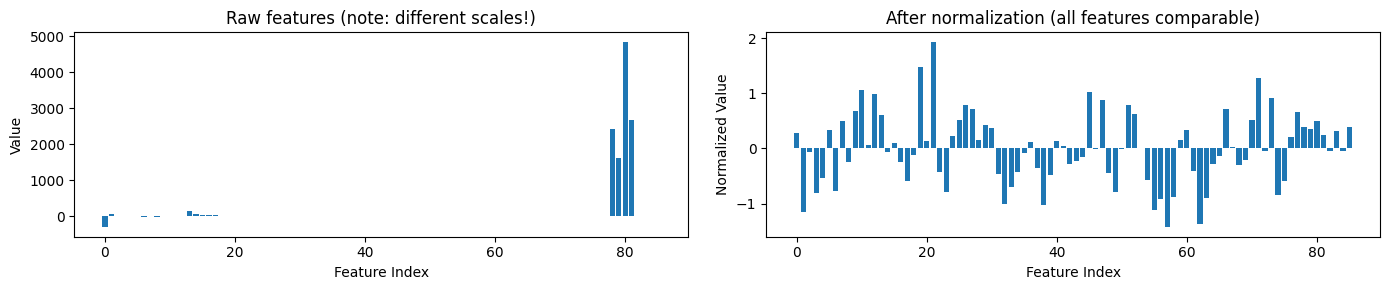

In [43]:
# Preview features for 3 samples
print("Feature examples:\n")
sample_indices = [0, len(X)//2, -1]

for i, idx in enumerate(sample_indices):
    row = df_clean.iloc[idx]
    print(f"Sample {i+1}: {row['language']} ({row['gender']})")
    print(f"  First 5 features (MFCCs): {X[idx][:5].round(3)}")
    print(f"  Last 4 features (spectral): {X[idx][-4:].round(3)}")
    print(f"  Feature stats - min: {X[idx].min():.3f}, max: {X[idx].max():.3f}")
    print()

# Show feature distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 3))

# Raw features
axes[0].bar(range(X.shape[1]), X[0])
axes[0].set_xlabel("Feature Index")
axes[0].set_ylabel("Value")
axes[0].set_title("Raw features (note: different scales!)")

# Normalized features (preview)
X_preview_norm = StandardScaler().fit_transform(X)
axes[1].bar(range(X.shape[1]), X_preview_norm[0])
axes[1].set_xlabel("Feature Index")
axes[1].set_ylabel("Normalized Value")
axes[1].set_title("After normalization (all features comparable)")

plt.tight_layout()
plt.show()

## Train/Test Split


In [44]:
# Split data (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class balance # type:ignore
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution:")
print(f"  Train: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"  Test:  {dict(zip(*np.unique(y_test, return_counts=True)))}")

Training set: 576 samples
Test set: 144 samples

Class distribution:
  Train: {'german': np.int64(144), 'italian': np.int64(144), 'korean': np.int64(144), 'spanish': np.int64(144)}
  Test:  {'german': np.int64(36), 'italian': np.int64(36), 'korean': np.int64(36), 'spanish': np.int64(36)}


## Data Augmentation (Training Only)

Augment training data to increase diversity. We apply augmentation at the audio level and extract features from augmented audio.


In [45]:
# Get training file paths for augmentation
train_indices = np.where(np.isin(np.arange(len(X)), 
    np.where(np.isin(X, X_train).all(axis=1))[0]))[0]

# Simpler: use df_clean indices that correspond to training data
df_train = df_clean.iloc[:len(X)].copy()
df_train['original_idx'] = range(len(df_train))

# Match training samples
train_mask = np.zeros(len(X), dtype=bool)
for i, x in enumerate(X_train):
    matches = np.where((X == x).all(axis=1))[0]
    if len(matches) > 0:
        train_mask[matches[0]] = True

df_train_files = df_train[train_mask]

def augment_audio(y, sr):
    """Apply random augmentation to audio"""
    augmented = []
    
    # Pitch shift (+/- 2 semitones)
    y_pitch_up = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
    y_pitch_down = librosa.effects.pitch_shift(y, sr=sr, n_steps=-2)
    augmented.extend([y_pitch_up, y_pitch_down])
    
    # Time stretch (faster/slower)
    y_fast = librosa.effects.time_stretch(y, rate=1.1)
    y_slow = librosa.effects.time_stretch(y, rate=0.9)
    augmented.extend([y_fast, y_slow])
    
    # Add noise
    noise = np.random.normal(0, 0.005, len(y))
    y_noisy = y + noise
    augmented.append(y_noisy)
    
    return augmented

def extract_features_from_audio(y, sr):
    """Extract features from audio array (not file)"""
    try:
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zero_crossing = librosa.feature.zero_crossing_rate(y)
        rms = librosa.feature.rms(y=y)
        
        features = np.concatenate([
            mfcc.mean(axis=1), mfcc.std(axis=1),
            mfcc_delta.mean(axis=1), mfcc_delta.std(axis=1),
            mfcc_delta2.mean(axis=1), mfcc_delta2.std(axis=1),
            spectral_centroid.mean(axis=1), spectral_centroid.std(axis=1),
            spectral_rolloff.mean(axis=1), spectral_rolloff.std(axis=1),
            zero_crossing.mean(axis=1), zero_crossing.std(axis=1),
            rms.mean(axis=1), rms.std(axis=1),
        ])
        return features
    except:
        return None

# Augment training data
print("Augmenting training data...")
X_aug_list = []
y_aug_list = []

for idx, row in tqdm(df_train_files.iterrows(), total=len(df_train_files)):
    try:
        y_audio, sr = librosa.load(row['filepath'], sr=SR)
        augmented_audios = augment_audio(y_audio, sr)
        
        for aug_audio in augmented_audios:
            feat = extract_features_from_audio(aug_audio, sr)
            if feat is not None:
                X_aug_list.append(feat)
                y_aug_list.append(row['language'])
    except:
        continue

X_aug = np.array(X_aug_list)
y_aug = np.array(y_aug_list)

# Combine original training data with augmented data
X_train_aug = np.vstack([X_train, X_aug])
y_train_aug = np.concatenate([y_train, y_aug])

print(f"\nOriginal training samples: {len(X_train)}")
print(f"Augmented samples added: {len(X_aug)}")
print(f"Total training samples: {len(X_train_aug)}")

Augmenting training data...


100%|██████████| 576/576 [15:42<00:00,  1.64s/it]


Original training samples: 576
Augmented samples added: 2880
Total training samples: 3456


## Normalization

Fit scaler on training data only, then transform both train and test.


In [46]:
# Fit scaler on training data only (no data leakage!)
# Using augmented data for fitting
scaler_aug = StandardScaler()
X_train_aug_norm = scaler_aug.fit_transform(X_train_aug)
X_test_aug_norm = scaler_aug.transform(X_test)

# Also normalize non-augmented version
scaler_no_aug = StandardScaler()
X_train_norm = scaler_no_aug.fit_transform(X_train)
X_test_norm = scaler_no_aug.transform(X_test)

print("Normalization complete!")
print(f"\nWith augmentation:")
print(f"  Train: {X_train_aug_norm.shape}, Test: {X_test_aug_norm.shape}")
print(f"\nWithout augmentation:")
print(f"  Train: {X_train_norm.shape}, Test: {X_test_norm.shape}")

Normalization complete!

With augmentation:
  Train: (3456, 86), Test: (144, 86)

Without augmentation:
  Train: (576, 86), Test: (144, 86)


## Save Processed Data


In [47]:
# Create output directories
os.makedirs("data/augmented", exist_ok=True)
os.makedirs("data/no_augmentation", exist_ok=True)

# Save augmented version
np.save("data/augmented/X_train.npy", X_train_aug_norm)
np.save("data/augmented/X_test.npy", X_test_aug_norm)
np.save("data/augmented/y_train.npy", y_train_aug)
np.save("data/augmented/y_test.npy", y_test)
joblib.dump(scaler_aug, "data/augmented/scaler.pkl")

# Save non-augmented version
np.save("data/no_augmentation/X_train.npy", X_train_norm)
np.save("data/no_augmentation/X_test.npy", X_test_norm)
np.save("data/no_augmentation/y_train.npy", y_train)
np.save("data/no_augmentation/y_test.npy", y_test)
joblib.dump(scaler_no_aug, "data/no_augmentation/scaler.pkl")

# Save metadata and feature names (shared)
df_clean.drop(columns=['features']).to_csv("data/metadata.csv", index=False)

feature_names = (
    [f"mfcc_{i}_mean" for i in range(N_MFCC)] +
    [f"mfcc_{i}_std" for i in range(N_MFCC)] +
    [f"mfcc_delta_{i}_mean" for i in range(N_MFCC)] +
    [f"mfcc_delta_{i}_std" for i in range(N_MFCC)] +
    [f"mfcc_delta2_{i}_mean" for i in range(N_MFCC)] +
    [f"mfcc_delta2_{i}_std" for i in range(N_MFCC)] +
    ["spectral_centroid_mean", "spectral_centroid_std"] +
    ["spectral_rolloff_mean", "spectral_rolloff_std"] +
    ["zero_crossing_mean", "zero_crossing_std"] +
    ["rms_mean", "rms_std"]
)
np.save("data/feature_names.npy", feature_names)

print("✅ Saved to ./data/")
print(f"\n📁 augmented/")
print(f"  - X_train.npy: {X_train_aug_norm.shape}")
print(f"  - X_test.npy: {X_test_aug_norm.shape}")
print(f"  - y_train.npy: {y_train_aug.shape}")
print(f"  - y_test.npy: {y_test.shape}")
print(f"  - scaler.pkl")
print(f"\n📁 no_augmentation/")
print(f"  - X_train.npy: {X_train_norm.shape}")
print(f"  - X_test.npy: {X_test_norm.shape}")
print(f"  - y_train.npy: {y_train.shape}")
print(f"  - y_test.npy: {y_test.shape}")
print(f"  - scaler.pkl")
print(f"\n📄 metadata.csv, feature_names.npy")

✅ Saved to ./data/

📁 augmented/
  - X_train.npy: (3456, 86)
  - X_test.npy: (144, 86)
  - y_train.npy: (3456,)
  - y_test.npy: (144,)
  - scaler.pkl

📁 no_augmentation/
  - X_train.npy: (576, 86)
  - X_test.npy: (144, 86)
  - y_train.npy: (576,)
  - y_test.npy: (144,)
  - scaler.pkl

📄 metadata.csv, feature_names.npy
